In [0]:
!unzip fruits-360.zip

In [3]:
import numpy as np
import keras
from keras import backend as K
from keras import regularizers
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [29]:
train_path = "fruits-360/Training"
test_path = "fruits-360/Test"
classes = ['Apple', 'Lemon', 'Orange', 'Pear']
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, validation_split=0.1)
train_batches = train_datagen.flow_from_directory(train_path, target_size=(224,224), batch_size=64,classes=classes,class_mode='categorical', subset='training' )
validation_batches = train_datagen.flow_from_directory(train_path, target_size=(224,224), batch_size=64, classes=classes, class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)
test_batches = test_datagen.flow_from_directory(test_path, target_size=(224,224), seed=42, batch_size=64,classes=classes,class_mode='categorical', shuffle = False )


Found 9727 images belonging to 4 classes.
Found 1078 images belonging to 4 classes.
Found 3614 images belonging to 4 classes.


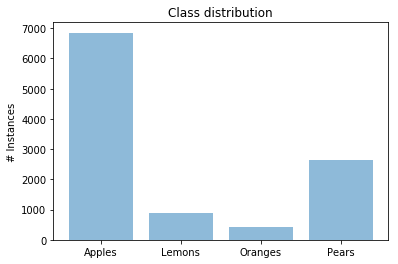

In [39]:
applesTrain = 0
orangesTrain = 0
lemonsTrain = 0
pearsTrain = 0
applesVal = 0
orangesVal = 0
lemonsVal = 0
pearsVal = 0
for i in range(len(train_batches.classes)):
    if (train_batches.classes[i] == 0):
        applesTrain += 1
    elif (train_batches.classes[i] == 1):
        lemonsTrain += 1
    elif (train_batches.classes[i] == 2):
        orangesTrain += 1
    else:
        pearsTrain += 1
for i in range(len(validation_batches.classes)):
    if (train_batches.classes[i] == 0):
        applesVal += 1
    elif (train_batches.classes[i] == 1):
        lemonsVal += 1
    elif (train_batches.classes[i] == 2):
        orangesVal += 1
    else:
        pearsVal += 1
arrayTrain = [applesTrain, lemonsTrain, orangesTrain, pearsTrain]
arrayVal = [applesVal, lemonsVal, orangesVal, pearsVal]
arrayTotal = [applesTrain+applesVal, lemonsTrain+lemonsVal, orangesTrain+orangesVal, pearsTrain+pearsVal]
objects = ('Apples', 'Lemons', 'Oranges', 'Pears')



y_pos = np.arange(len(arrayTotal))
plt.bar(y_pos, arrayTotal, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('# Instances')
plt.title('Class distribution')

plt.show()


In [6]:
mobile = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 0s 0us/step


In [19]:
#Grabs the output from the 6th to last layer since we will be retraining the last 5 layers.
x = mobile.layers[-6].output
#Add our own output layer, 4 classes -> Apple, Lemon, Pear, Orange
predictions = Dense(4, activation = 'softmax')(x)
model = Model(inputs=mobile.input,outputs=predictions)
#model.summary()
#Only train last 5 layers, freeze all others.
for layer in model.layers[:-5]:
  layer.trainable = False
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
#Steps per epoch should be #images in train / train batch size, validatio_steps = #images in validation / validion batch size. Takes way too long

h1 = model.fit_generator(train_batches, steps_per_epoch=152, validation_data=validation_batches, validation_steps=17, epochs=30, verbose=2)

In [30]:
testLabels = test_batches.classes
print(testLabels)
print(test_batches.class_indices)
# Steps -> #images / test batch size
predictions = model.predict_generator(test_batches, steps=57, verbose = 2)

[0 0 0 ... 3 3 3]
{'Apple': 0, 'Lemon': 1, 'Orange': 2, 'Pear': 3}


In [31]:
loss, acc = model.evaluate_generator(test_batches, steps=57, verbose=2)
print("Loss : ", loss)
print("Acc : ", acc)

Loss :  0.4224867704316693
Acc :  0.8884892085011519


In [0]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    print(cm)
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

3614
Confusion matrix without normalization
[[1810   21   17  290]
 [   2  287    5   36]
 [   0    0  141   19]
 [  10    0    3  973]]


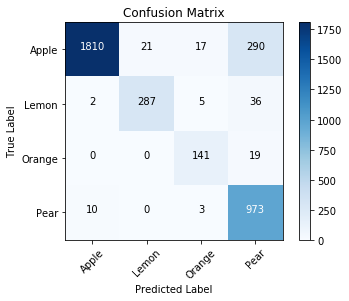

In [33]:
print(len(testLabels))
cm = confusion_matrix(testLabels, predictions.argmax(axis=1))
cm_plot_labels = ['Apple', 'Lemon', 'Orange', 'Pear']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

Epoch 1/30
 - 30s - loss: 0.2472 - acc: 0.9209 - val_loss: 0.4139 - val_acc: 0.8396
Epoch 2/30
 - 28s - loss: 0.0425 - acc: 0.9948 - val_loss: 0.2411 - val_acc: 0.9276
Epoch 3/30
 - 27s - loss: 0.0244 - acc: 0.9967 - val_loss: 0.2570 - val_acc: 0.9259
Epoch 4/30
 - 28s - loss: 0.0155 - acc: 0.9983 - val_loss: 0.3030 - val_acc: 0.9099
Epoch 5/30
 - 28s - loss: 0.0111 - acc: 0.9992 - val_loss: 0.3542 - val_acc: 0.8757
Epoch 6/30
 - 28s - loss: 0.0087 - acc: 0.9995 - val_loss: 0.2429 - val_acc: 0.9494
Epoch 7/30
 - 29s - loss: 0.0072 - acc: 0.9993 - val_loss: 0.2990 - val_acc: 0.9012
Epoch 8/30
 - 28s - loss: 0.0064 - acc: 0.9997 - val_loss: 0.2510 - val_acc: 0.9361
Epoch 9/30
 - 28s - loss: 0.0051 - acc: 0.9997 - val_loss: 0.1999 - val_acc: 0.9542
Epoch 10/30
 - 28s - loss: 0.0048 - acc: 0.9997 - val_loss: 0.2265 - val_acc: 0.9391
Epoch 11/30
 - 28s - loss: 0.0042 - acc: 0.9997 - val_loss: 0.2582 - val_acc: 0.9201
Epoch 12/30
 - 28s - loss: 0.0039 - acc: 0.9996 - val_loss: 0.2015 - val_a

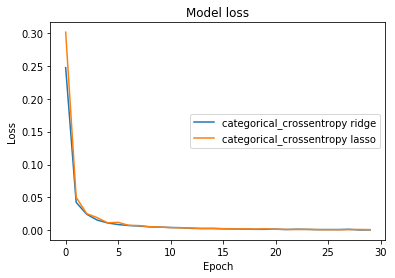

In [38]:
for regularizer in [regularizers.l2(0.05), regularizers.l1(0.05)]: 
  #Grabs the output from the 6th to last layer since we will be retraining the last 5 layers.
  x = mobile.layers[-6].output
  #Add our own output layer, 4 classes -> Apple, Lemon, Pear, Orange
  predictions = Dense(4, activation = 'softmax')(x)
  model = Model(inputs=mobile.input,outputs=predictions)
  #model.summary()
  #Only train last 5 layers, freeze all others.
  for layer in model.layers[:-5]:
    layer.trainable = False

  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
  #Steps per epoch should be #images in train / train batch size, validatio_steps = #images in validation / validion batch size. Takes way too long
  # 152 117 30
  history = model.fit_generator(train_batches, steps_per_epoch=152, validation_data=validation_batches, validation_steps=117, epochs=30, verbose=2)
  plt.plot(history.history['loss'],label='categorical_crossentropy' + " " + ("lasso" if regularizer.l1 > 0 else "ridge"))

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='center right')
plt.show() 